<a href="https://colab.research.google.com/github/Elisakova/github_welcom/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F__%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%98%D1%81%D0%B0%D0%BA%D0%BE%D0%B2%D0%B0_%D0%95_%D0%A1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание временных рядов

## Введение. Постановка целей и задач.

Солнце оказывает наибольшее влияние на климат на Земле. Впервые было замечено, что солнечные пятна влияют на Землю, когда ученые поняли, что повышенная активность солнечных пятен создает повышенные помехи для магнитных приборов на поверхности земли. Также ученые  связывают изменения в солнечной активности с изменением климата,  влияние на  здоровье человека .
Цень  прогноз числа пятен


### Импорт Датафрейма, библиотек, написание функций.

В этом блоке мы импортируем все, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.

In [3]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pmdarima-2.0.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.9 MB)
  Using cached statsmodels-0.13.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 


In [5]:
import statsmodels.api as sm
data = sm.datasets.sunspots.load_pandas()

In [6]:
df=data.data
df.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


Знакомство с данными.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         309 non-null    float64
 1   SUNACTIVITY  309 non-null    float64
dtypes: float64(2)
memory usage: 5.0 KB


In [ ]:
df.dtypes

YEAR           float64
SUNACTIVITY    float64
dtype: object

In [ ]:
df.shape

(309, 2)

In [ ]:
df.isnull().sum()

YEAR           0
SUNACTIVITY    0
dtype: int64

Выводы по разделу: Датасет  содержит 309  наблюдений, две  переменные , тип переменной -float , переменная  YEAR -  год  наблюжени, SUNACTIVITY -  количество  пятен на солнце.  SUNACTIVITY - целевая переменная . В данных  нет пропущених значений. 



## Предобработка данных

In [8]:
import datetime
df['YEAR'] = df['YEAR'].astype('int')
df['DATE'] = df['YEAR'].map(lambda x: datetime.date(x, 1, 1))
df.head()


,YEAR,SUNACTIVITY,DATE
0,1700,5.0,1700-01-01
1,1701,11.0,1701-01-01
2,1702,16.0,1702-01-01
3,1703,23.0,1703-01-01
4,1704,36.0,1704-01-01


In [9]:
df.index=pd.Index(pd.date_range("1700", end="2009", freq="A-DEC"))
df.head()

,YEAR,SUNACTIVITY,DATE
1700-12-31,1700,5.0,1700-01-01
1701-12-31,1701,11.0,1701-01-01
1702-12-31,1702,16.0,1702-01-01
1703-12-31,1703,23.0,1703-01-01
1704-12-31,1704,36.0,1704-01-01


### Вывод по этапу. Т.к. датасете не  было пропущенных  данных,  дублирующих  значений и  данных  типа object или str не применялись методы обработки данных. Нормализация данных  включала  только  подготовку атрибута дата для анализа сезонной состовляющей 


## EDA или разведочный анализ данных.

In [10]:
df.describe()

,YEAR,SUNACTIVITY
count,309.000000,309.000000
mean,1854.000000,49.752104
std,89.344838,40.452595
min,1700.000000,0.000000
25%,1777.000000,16.000000
50%,1854.000000,40.000000
75%,1931.000000,69.800000
max,2008.000000,190.200000


In [11]:
import plotly.express as px
fig=px.line(df, x='YEAR', y='SUNACTIVITY', title="Количество солнечных  пятен по годам" )
fig.show()


ETS декомпозиция

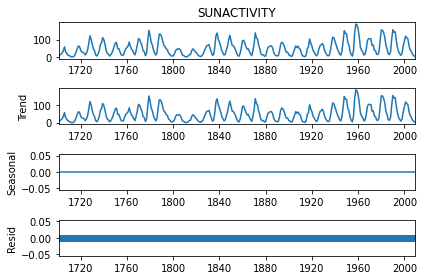

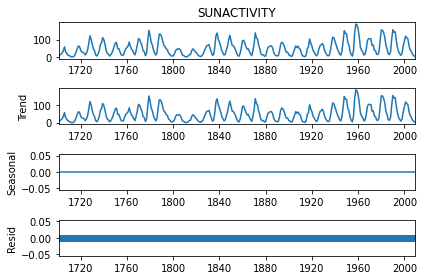

In [12]:
decomposition=sm.tsa.seasonal_decompose(df['SUNACTIVITY'], model='additive')
result=seasonal_decompose(df['SUNACTIVITY'], model='add')
result.plot()

 Выводы по разделу: При построении графика на основе  данных можно заметить некоторые явные шаблоны. Временные ряды имеют очевидную сезонность и общий тренд на увеличение.

**Построение моделей, анализ результатов.**

Модель ARIMA.

Описание  модели :описывает корреляцию между точками данных и учитывает разницу значений.
ARIMA использует три основных параметра (p, d, q).Эти три параметра учитывают сезонность, тенденцию и шум в наборах данных.
AR (авторегрессия)-p, I (разность) -d и MA (скользящая средняя)-q.
При построении модели будем использовать Auto ARIMA для  определения значения p и q. 

1.Делим данные на обучающую и проверочную выборки

In [40]:
train= df.iloc[:-15]
test=df.iloc[-15:]  
test.shape



(15, 3)

строим график наших данных

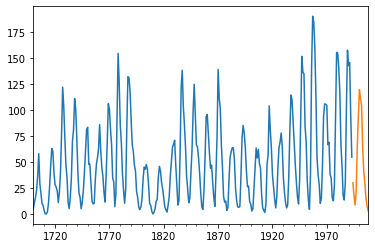

In [16]:
train['SUNACTIVITY'].plot()
test['SUNACTIVITY'].plot()

2.Строим модель

2.1. Расчет гиперпараметров (p,d,q)

In [13]:

from pmdarima.arima.auto import AutoARIMA
auto_arima(df['SUNACTIVITY'], seasonal=False, year=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1280.477
Date:                Sun, 05 Feb 2023   AIC                           2572.954
Time:                        07:45:23   BIC                           2595.335
Sample:                    12-31-1700   HQIC                          2581.903
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6145      0.026     62.096      0.000       1.564       1.665
ar.L2         -0.9354      0.022    -41.820      0.000      -0.979      -0.892
ma.L1         -1.4392      0.059    -24.590      0.000      -1.554      -1.324
ma.L2          0.4545      0.095      4.783      0.000       0.268       0.641
ma.L3          0.1285      0.060      2.143      0.032       0.011       0.246
sigma2       236.7573     16.333     14.495      0.000     204.744     268.770
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                43.72
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.54
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

	SARIMAX(2, 1, 3)	- гиперпараметры 

3.Создаем и обучаем модель 

In [30]:
model=SARIMAX(train['SUNACTIVITY'], order=(2,1,3)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  294
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1221.343
Date:                Sun, 05 Feb 2023   AIC                           2454.687
Time:                        08:43:16   BIC                           2476.768
Sample:                    12-31-1700   HQIC                          2463.530
                         - 12-31-1993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6061      0.028     57.845      0.000       1.552       1.661
ar.L2         -0.9304      0.023    -39.601      0.000      -0.976      -0.884
ma.L1         -1.4290      0.060    -23.660      0.000      -1.547      -1.311
ma.L2          0.4439      0.097      4.556      0.000       0.253       0.635
ma.L3          0.1254      0.063      1.998      0.046       0.002       0.248
sigma2       241.9604     17.176     14.087      0.000     208.297     275.624
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                38.04
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.53
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

4.Создаем прогноз

In [57]:
xstart=len(train)
xend=len(train)+len(test)-1
forecast = model.predict(start=xstart, end=xend, dynamic=False, typ='level').rename('SARIMAX(2, 1, 3)	')
forecast.head()

1994-12-31    29.307723
1995-12-31    21.009065
1996-12-31    31.010730
1997-12-31    54.796233
1998-12-31    83.693245
Freq: A-DEC, Name: SARIMAX(2, 1, 3)\t, dtype: float64

5.Сравниваем предсказание с данными выборки 

In [58]:
for i in range(len(forecast)):
  print(f"predicted={forecast[i]:<11.10}, expected={test['SUNACTIVITY'][i]}")

predicted=29.30772315, expected=29.9
predicted=21.00906473, expected=17.5
predicted=31.01073035, expected=8.6
predicted=54.79623266, expected=21.5
predicted=83.69324525, expected=64.3
predicted=107.9750744, expected=93.3
predicted=120.0883108, expected=119.6
predicted=116.9511771, expected=111.0
predicted=100.6418734, expected=104.0
predicted=77.36569112, expected=63.7
predicted=55.15558595, expected=40.4
predicted=41.14000245, expected=29.8
predicted=39.29408226, expected=15.2
predicted=49.36989976, expected=7.5
predicted=67.27062796, expected=2.9


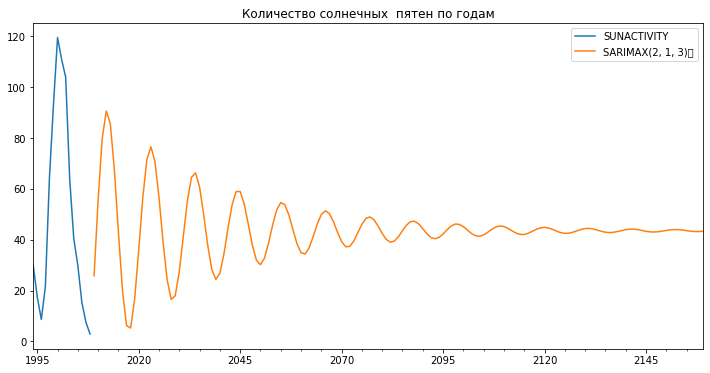

In [71]:
xtitle="Количество солнечных  пятен по годам"

ax=test['SUNACTIVITY'].plot(legend=True, figsize=(12,6), title=xtitle)
forecast.plot(legend=True)
ax.autoscale(axis='x', tight=True)


6.Рассчитываем качество полученной модели и прогноза



In [60]:
from sklearn.metrics import mean_squared_error
error_mse=mean_squared_error(test['SUNACTIVITY'], forecast)
print(f"SARIMAX(2, 1, 3) MSE error:{error_mse}")


SARIMAX(2, 1, 3) MSE error:618.1464764830586


In [61]:
from statsmodels.tools.eval_measures import rmse
error_rmse=rmse(test['SUNACTIVITY'], forecast)
print(f"SARIMAX(2, 1, 3)	RMSE error:{error_rmse}")

SARIMAX(2, 1, 3)	RMSE error:24.86255168889667


6.Применеие модели к валидационной выборке

In [77]:
model=SARIMAX(df['SUNACTIVITY'], order=(2,1,3))
result=model.fit()

fcast=result.predict(len(df), len(df)+15, typ='levels' ).rename('SARIMAX(2, 1, 3)	')

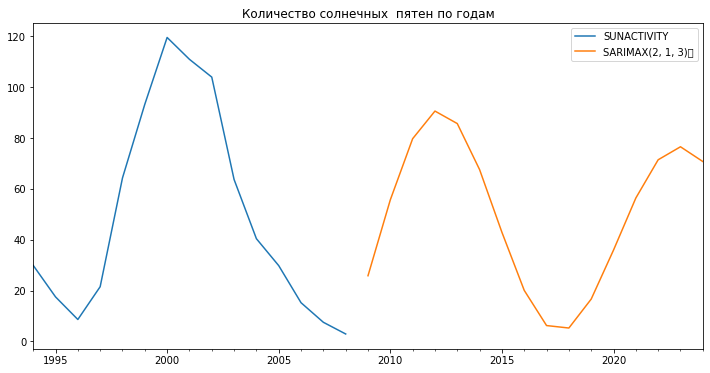

In [78]:
xtitle="Количество солнечных  пятен по годам"

ax=test['SUNACTIVITY'].plot(legend=True, figsize=(12,6), title=xtitle)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)


В данном блоке у нас должно быть от трёх до четырех подглав:    
- Разделение датасета на тренировочную и тестовую (валидационную) выборки, проверка на статичность, построение графиков автокорреляции и частичной автокорреляции, разбивка на сезонность и тренд.
- Применение 1 способа прогнозирования;
- Применение 2 способа прогнозирования;
- (Применение 3 способа прогнозирования); **По желанию**

Первый пункт - разделение датасета - универсален, данные из него не нужно обновлять или заного рассчитывать.

Остальные три пункта содержат примерно одинаковый алгоритм действий:    
1. Описываем вкратце модель.
2. Создаем модель.
3. Обучаем модель.
4. Создаем прогноз.
5. Сравниваем прогноз и предсказание. 
6. Рассчитываем качество полученной модели и прогноза.
7. Делаем выводы по прогнозу.


Какие модели у нас есть:
- В рамках курса мы рассмотрели модель ARIMA, её улучшенную версию SARIMA. Обязательно попробуйте использовать эту модель;
- Модель экспаненционного сглаживающего среднего;
- Модель Хольта-Винтерса.

Последние 2 модели мы не изучали, поэтому можно попробовать использовать составные от модели ARIMA, которые мы рассматривали в лекции - AR, MA.

После получения прогноза отобразите графики **прогноз vs факт**, чтобы визуально можно было посмотреть на то, как точно построен прогноз. 

Как понять, подходит ли модель. Попробуйте использовать следующие методы рассчета ошибки:
- MAPE или средняя абсолютная ошибка в процентах.
- RMSE - квадратный корень из среднеквадратичной ошибки.
- MSE - среднеквадратичный корень (связан  с RMSE).

В конце - сравните полученные метрики с ошибками и выберите ту модель, которая точнее всего создает прогноз.

Ещё один важный момент - горизонт прогнозирования и сравнение прогноза с данными. Горизонт планирования нужно сделать небольшим - примерно 10-15 наблюдений (то есть 10-15 дней). И в ошибку нужно сравнивать с таким же числом наблюдений за тот же период по реальным данным!

Также отмечу, что прогноз, скорее всего, будет не самым точным, а возможно, он совсем покажет что-то непонятное.

## Выводы

В данном блоке опишите общие выводы по работе: что было сделано, что было получено. Помните, отрицательный результат - тоже результат. Поэтому указывайте информацию честно и беспристратно. 